<a href="https://colab.research.google.com/github/danielsaggau/LDSI_Project/blob/master/LDSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if os.environ.get("COLAB_GPU", False):
    !pip install -U datasets transformers
import os
import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)
PATH_BASE = "/drive/My Drive"

In [41]:
PATH_BASE ="/content"

In [10]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.24.60.50:8470']


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8


In [15]:
data = pd.read_json("/content/flat_list.json")
data.to_csv("/content/data.csv", index=False)


In [ ]:
data[:100]

In [22]:
data = pd.read_csv("/content/data.csv")
data = Dataset.from_pandas(data)
data.rename_column("0", "text")

Dataset({
    features: ['text'],
    num_rows: 7651
})

In [23]:
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"
MAX_TOKENS = 256 # was 128

tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

# adding further special cases
special_cases = ['Cir.','Fed.','No.','NO','App.','Civ.', 'Dkt.', 'et al.','Nos.','U.S.C.','F.',
                 'R.', 'n.', 'v.', 'Univ.', 'Jr.','I.N.S.', 'OR.', 'REV.', 'STAT.','D.C.']

tokenizer.add_tokens(special_cases, special_tokens = False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


20

In [24]:
output = {}

# defining tokenizer function
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["0"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
    num_proc=strategy.num_replicas_in_sync,
    remove_columns=["0"],
    load_from_cache_file=True,
)
data.save_to_disk("/content/dataset_format")
data = datasets.load_from_disk("/content/dataset_format")
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.20, shuffle=True, seed=1, load_from_cache_file=True
)

In [46]:
# convert to tensors and split data
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

BATCH_SIZE_PER_REPLICA = 28
EPOCHS = 6
INITAL_LEARNING_RATE = 0.001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)


In [47]:
# prepare data for consumption
train_ds = (train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True))
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)
# reference note:
# initialize model, use_cache=False important! else wrong shape at loss calc
with strategy.scope():
    model = TFGPT2LMHeadModel.from_pretrained(
        "distilgpt2",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model.resize_token_embeddings(len(tokenizer))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=model.compute_loss)
    model.summary()



All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  81928704  
Total params: 81,928,704
Trainable params: 81,928,704
Non-trainable params: 0
_________________________________________________________________


In [48]:
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)

Model Params:
batch_size: 224
Epochs: 8
Step p. Epoch: 27
Initial Learning rate: 0.001


In [ ]:
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=6,
    verbose=1,
)

In [ ]:
# save model
hist.save("model")

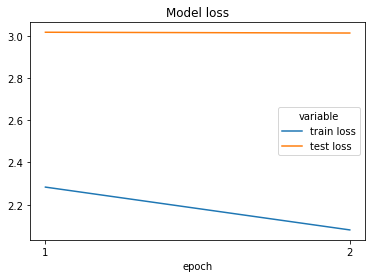

In [45]:
# plotting the loss
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

# load model